#**Лабораторная работа по ММАД №5**

##**Выполнил: Степанищев Степан Владимирович, гр. 23171**

##***Задание 1***

###Подключаем библиотеки

---


In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering


###Вводим данные задачи

---



In [2]:
V = 6

d = np.array(
 [[40 + V, 10 + V, 1],
 [100 - V, 110 - V, 2],
 [30 + V, 20 + V, 3],
 [25 + V, 15 + V, 4],
 [V, 105 - V, 5],
 [100 + V, 120 + V, 6],
 [230 - V, 220 - V, 7],
 [110 + V, 90 + V, 8],
 [120 + V, 200 - V, 9],
 [180 - V, 160 - V, 10]])

df = pd.DataFrame(data = d, columns = ('X1', 'X2', 'District'))
X = df.drop(columns=['District'])


###Строим иерархию группировки, начиная от кластеров из одного элемента. Для определения расстояния между кластерами будем использовать евклидову метрику и single/complete linkage


---



In [3]:
comp_link_clustering = AgglomerativeClustering(metric='euclidean', distance_threshold = 0, n_clusters = None,
 compute_full_tree = True, linkage = 'complete')
clusters_cl = comp_link_clustering.fit(X)

single_link_clustering = AgglomerativeClustering(metric='euclidean', distance_threshold = 0, n_clusters = None,
 compute_full_tree = True, linkage = 'single')
clusters_sl = single_link_clustering.fit(X)


###Рисуем дендрограммы

---



Стягиваем рисовалку дендрограмм вот отсюда: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Text(0.5, 0, 'Index of point')

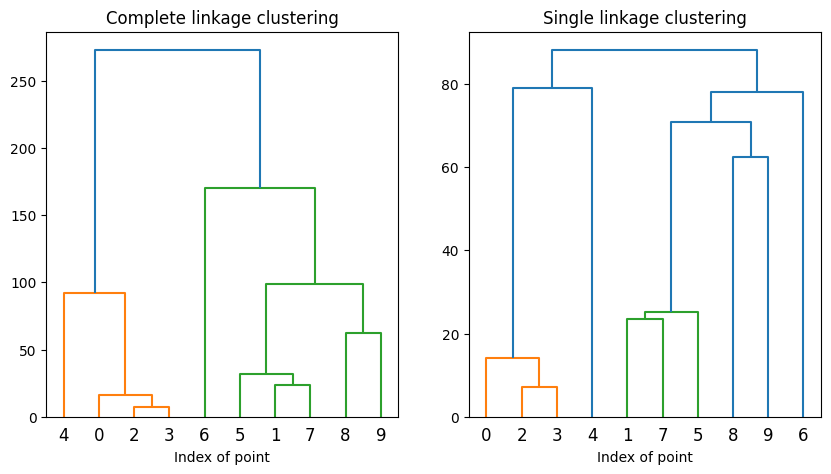

In [5]:
scale = 5
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (2 * scale, scale))

ax[0].set_title('Complete linkage clustering')
plot_dendrogram(clusters_cl, ax = ax[0])
ax[0].set_xlabel('Index of point')

ax[1].set_title('Single linkage clustering')
plot_dendrogram(clusters_sl, ax = ax[1])
ax[1].set_xlabel('Index of point')

**Вывод:** оба метода дают нам одинаковые кластеры, различается только расстояние между ними.

##***Задание 2***

###Пробуем разные методы снижения размерности для данных из лабораторной работы №3

---

In [6]:
train_df = pd.read_csv('/content/training.csv')

train_X = train_df.drop('class', axis=1)
train_Y = train_df.iloc[:, 0]

###Начинаем с PCA.

---

In [7]:
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(train_X)

In [8]:
def class2int(a):
  num = 0
  if a == 's ':
    num = 1
  elif a == 'h ':
    num = 2
  elif a == 'd ':
    num = 3
  else:
    num = 4
  return num

Text(0.5, 0, 'X1')

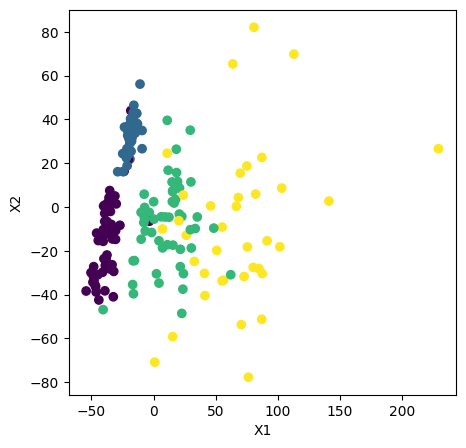

In [9]:
scale = 5
fig, ax = plt.subplots(figsize = (scale, scale))
ax.scatter(XPCAreduced[:, 0], XPCAreduced[:, 1], c=list(map(class2int, train_Y)))
ax.set_ylabel('X2')
ax.set_xlabel('X1')

**Вывод:** в этих осях в принципе неплохо разделились классы. Только желтый с зеленым немного смешались, но в целом можно нарисовать границу.

###Переходим к tSNE.

---

In [10]:
RS = 12345
XTSNEreduced = TSNE(random_state = RS).fit_transform(train_X)

Text(0.5, 0, 'X1')

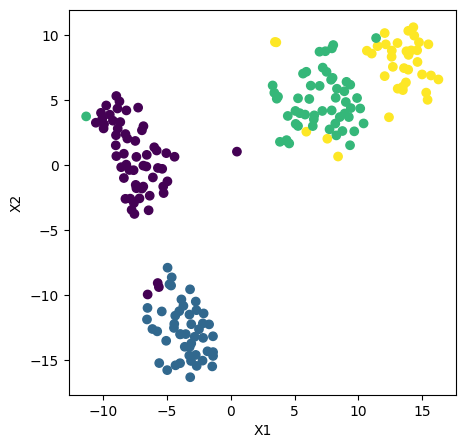

In [11]:
scale = 5
fig, ax = plt.subplots(figsize = (scale, scale))
ax.scatter(XTSNEreduced[:, 0], XTSNEreduced[:, 1], c=list(map(class2int, train_Y)))
ax.set_ylabel('X2')
ax.set_xlabel('X1')

**Вывод:** для данных этой задачи tSNE лучше, с точки зрения разделимости классов, уменьшил размерность задачи, чем PCA. Оказывается, на наших данных выгоднее стараться сохранять расстояние между точками, чем структуру (т.е. многообразие) в целом.

###Заканчиваем обзор на методе UMAP.

---

Если PCA старается сохранить глобальную структуру данных, а tSNE локальную, то UMAP более гибкий. Варьируя параметр n_neighbors, мы по-сути выбираем окрестность вокруг каждой точки, в которой мы хотим сохранить вид данных. Ну и ещё он хорошо параллелится.

In [19]:
nhood = 5
XUMAPreduced = umap.UMAP(n_components = 2, n_neighbors = nhood, random_state = RS).fit_transform(train_X)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 0, 'X1')

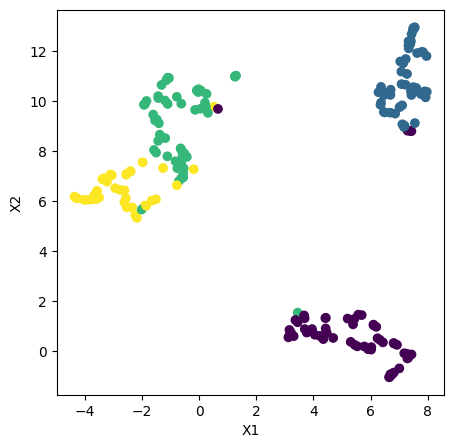

In [20]:
scale = 5
fig, ax = plt.subplots(figsize = (scale, scale))
ax.scatter(XUMAPreduced[:, 0], XUMAPreduced[:, 1], c=list(map(class2int, train_Y)))
ax.set_ylabel('X2')
ax.set_xlabel('X1')

**Вывод:** в целом, результат не сильно отличается от tSNE. При увеличении параметра n_neighbors картинка будет больше похожа на PCA (что справедливо).

**Общий вывод:** все 3 метода довольно хорошо справились с задачей уменьшения размерности. В двумерном пространстве довольно хорошо разделяются синий и фиолетовый классы; желтый и зеленый разделяются хуже, вне зависимости от применяемого метода. Алгоритм PCA старается сохранить "картинку" в целом, tSNE работает локально, а UMAP является более универсальным и гибким.